### 1. Import the essential libraries

In [33]:
import os
import sys
import cv2
import random
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import skimage
from skimage.color import rgb2lab, lab2rgb
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

params = {"ytick.color" : "yellowgreen",
          "xtick.color" : "yellowgreen",
          "axes.labelcolor" : "yellowgreen",
          "axes.edgecolor" : "yellowgreen"}
plt.rcParams.update(params)

### 1.1 Define some helpful functions

In [34]:
def surf_feature_extraction_v2(image, indices, hessianThreshold=400, nOctaves=3, n_keypoints=10, surf_window=20):
    # construct a mask for the segment
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold=hessianThreshold, nOctaves=nOctaves)
    key_points = [cv2.KeyPoint(y, x, surf_window) for (x,y) in indices]
    key_points = sorted(key_points, key=lambda x: -x.response)[:n_keypoints]
    key_points, description = surf.compute(image, key_points)
    
    if len(key_points) != 0:
        description = description.flatten()
    else:
        description = np.array([])
        
    fearute_vector_size = (n_keypoints * 64)
    if description.size < fearute_vector_size:
        description = np.concatenate([description, np.zeros(fearute_vector_size - description.size)])
    
    return (key_points, description)

In [35]:
def calc_energy_and_amplitude(filtered_img):
    '''
    Return a list of values:
      * Local Energy = summing up the squared value of each matrix value from a response matrix
      * Mean Amplitude = sum of absolute values of each matrix value from a response matrix
    '''
    local_energy = np.sum(np.square(filtered_img))
    mean_amplitude = np.sum(np.absolute(filtered_img))
    return [local_energy, mean_amplitude]

def gabor_feature_extraction_v2(image_lab_L, theta_range=[0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, 3*np.pi/4, 5*np.pi/6], scale_range=[3, 6, 13, 28, 58]):
    sp_local_energy = []
    sp_mean_amplitude = []
    for scale in scale_range:
        for angle in theta_range:
            g_kernel = cv2.getGaborKernel(ksize=(20, 20), sigma=scale, theta=angle, lambd=7, gamma=0.9, psi=1.5, ktype=cv2.CV_32F)
            filtered_img = cv2.filter2D(image_lab_L, cv2.CV_8UC3, g_kernel)
            
            lcl_enrgy, mn_amplitude = calc_energy_and_amplitude(filtered_img)
            
            sp_local_energy.extend([lcl_enrgy])
            sp_mean_amplitude.extend([mn_amplitude])
            
    return (sp_local_energy, sp_mean_amplitude)

In [36]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

### 2. Set the paths for *train* and *test* data

In [37]:
# train_images_path = os.path.join("/media/andretri7/WD/Datasets/emilwallner-datasets-colornet-2/images/Train")
# test_images_path  = os.path.join("/media/andretri7/WD/Datasets/emilwallner-datasets-colornet-2/images/Test")
train_images_path = os.path.join("/media/andretri7/WD/Datasets/flower_images/flower_images")

res_path = os.path.join('.', 'res_all')

### 2.1. Loading
  * #### The Train Image (RGB & LAB)
  * #### The Color Palette
  * #### The OvR SVM Classifier
  * #### The PCA Model

In [38]:
train_image_rgb = cv2.imread(os.path.join(res_path, 'test_image.png'))
train_image_rgb = cv2.cvtColor(train_image_rgb, cv2.COLOR_BGR2RGB)

train_image_lab = rgb2lab(train_image_rgb/255)

colorPalette = joblib.load(os.path.join(res_path, 'colorPalette.joblib'))

ovr_clf = joblib.load(os.path.join(res_path, 'TextureColorClassifierOvR.joblib'))
pca = joblib.load(os.path.join(res_path, 'DecompositionPCA.joblib'))
stdScaler = joblib.load(os.path.join(res_path, 'stdScaler.joblib'))

### 3. Colorizing an Image without using Graph Cuts

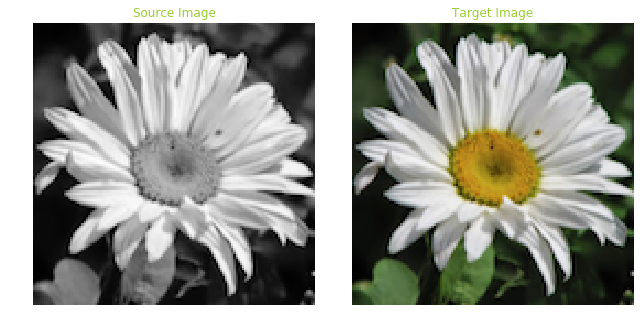

In [39]:
test_image = train_image_lab[:,:,0]

plt.figure(figsize=(9,9))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Source Image', color='yellowgreen')
plt.imshow(test_image, cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Target Image', color='yellowgreen')
plt.imshow(train_image_rgb, cmap='gray')
plt.tight_layout()

### 3. Colorizing an Image without using Graph Cuts (cont.) - This time we perform colorization per superpixel

/home/andretri7/anaconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
/home/andretri7/anaconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
/home/andretri7/anaconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[

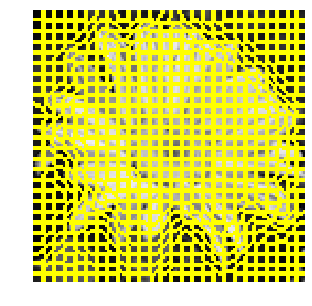

In [40]:
# apply SLIC and extract (approximately) the supplied number of segments
image_segments = slic(test_image, convert2lab=False, multichannel=False, n_segments=600, sigma=5) 
# Show the Segmented Image
# plt.imshow(mark_boundaries(train_image_rgb, segments))
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(mark_boundaries(train_image_rgb[:,:,0], image_segments), cmap='gray')

In [41]:
colorized_image = np.zeros_like(train_image_lab)
colorized_image[:,:,0] = test_image

for (i, segVal) in tqdm_notebook(enumerate(np.unique(image_segments)), total=len(np.unique(image_segments))):
    # construct a mask for the segment
    mask = np.zeros(test_image.shape, dtype = "uint8")
    mask[image_segments == segVal] = 255
    superpixel = cv2.bitwise_and(test_image, test_image, mask=mask)
    
    superpixel_surf = surf_feature_extraction_v2(np.uint8(test_image), np.argwhere(image_segments == segVal), n_keypoints=7, surf_window=20)[1] 
    superpixel_gabor = np.hstack(gabor_feature_extraction_v2(np.uint8(superpixel)))
    superpixel_vector = pca.transform(stdScaler.transform(np.hstack((superpixel_surf, superpixel_gabor)).reshape((1,-1))))
    pred_color_class = ovr_clf.predict(superpixel_vector)[0]
        
    pred_color_a = colorPalette.cluster_centers_[int(pred_color_class)][0]
    pred_color_b = colorPalette.cluster_centers_[int(pred_color_class)][1]

    colorized_image[image_segments==segVal, 1:3] = np.array([pred_color_a, pred_color_b])

* #### Use the Median Filter for each Color Channel to eliminate any Outlier Pixels

/home/andretri7/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


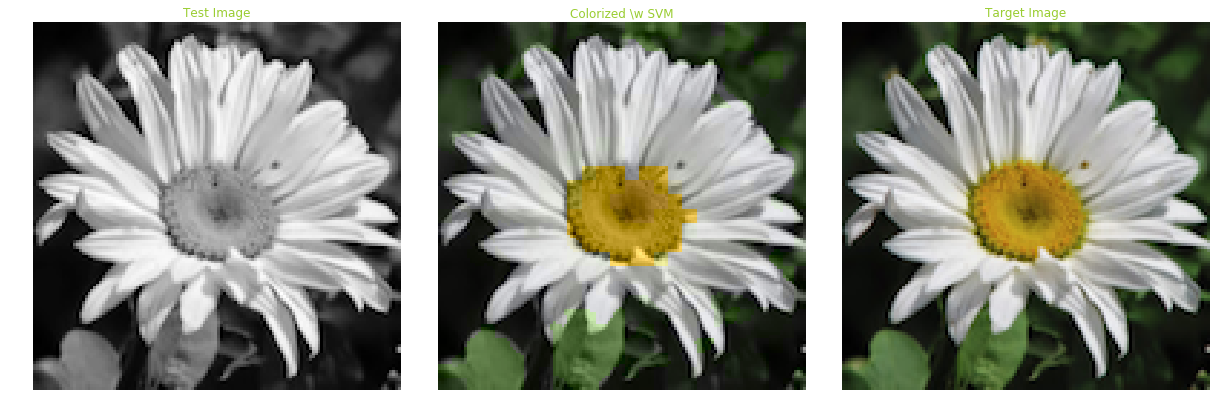

In [42]:
plt.figure(figsize=(17,17))
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Test Image', color='yellowgreen')
plt.imshow(test_image, cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.title('Colorized \w SVM', color='yellowgreen')
plt.imshow(lab2rgb(colorized_image))
plt.subplot(1,3,3)
plt.axis('off')
plt.title('Target Image', color='yellowgreen')
plt.imshow(train_image_rgb)
plt.tight_layout()

### Looks pretty awful doesn't it? Let's see if the application of the Graph Cuts algorithm alleviates that problem
---
### 4. Colorizing an Image using Graph Cuts

In [48]:
ovr_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15.])

### 4.1. The Sobel Filter (i.e. Getting the image Gradients)

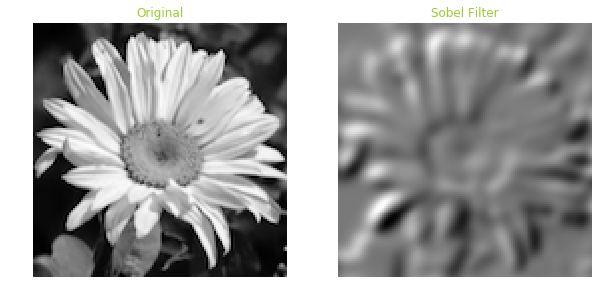

In [117]:
blur_width=3
test_image_blurred = cv2.GaussianBlur(test_image, (0,0), blur_width)
sf_hr = cv2.Sobel(test_image_blurred, cv2.CV_64F, 1,0)  # x
sf_vr = cv2.Sobel(test_image_blurred, cv2.CV_64F, 0,1)  # y

# img_grad = np.hypot(sf_hr, sf_vr)
img_grad = 0.5*sf_hr + 0.5*sf_vr

plt.figure(figsize=(10,10))
plt.subplot(1,2,1), plt.axis('off'), plt.title('Original', color='yellowgreen'), plt.imshow(test_image, cmap='gray')
plt.subplot(1,2,2), plt.axis('off'), plt.title('Sobel Filter', color='yellowgreen'), plt.imshow(img_grad, cmap='gray')
plt.show()

### 4.2 Compute the SVM Margins for each Feature Vector _(these will be used as the proxy for the conditional probability of a color given a pixel)_
---
### 4.3 Creating the Graph Matrix from the SVM Margins

In [118]:
label_costs = np.zeros((test_image.shape[0], test_image.shape[1], len(ovr_clf.classes_)))

for (i, segVal) in tqdm_notebook(enumerate(np.unique(image_segments)), total=len(np.unique(image_segments))):
    # construct a mask for the segment
    mask = np.zeros(test_image.shape, dtype = "uint8")
    mask[image_segments == segVal] = 255
    superpixel = cv2.bitwise_and(test_image, test_image, mask=mask)
    
    superpixel_surf = surf_feature_extraction_v2(np.uint8(test_image), np.argwhere(image_segments == segVal), n_keypoints=7, surf_window=20)[1] 
    superpixel_gabor = np.hstack(gabor_feature_extraction_v2(np.uint8(superpixel)))
    superpixel_vector = pca.transform(stdScaler.transform(np.hstack((superpixel_surf, superpixel_gabor)).reshape((1,-1))))
    
    pred_margin = ovr_clf.decision_function(superpixel_vector).flatten()
#     label_costs[image_segments==segVal] = sigmoid(pred_margin)    # The confidence of each SVM classifier
    label_costs[image_segments==segVal] = -1*pred_margin    # The confidence of each SVM classifier    

In [93]:
label_costs.shape

(128, 128, 16)

### 4.4. Introducing... The Graph Cuts Algorithm

In [119]:
from pygco import cut_simple_vh, cut_simple

In [120]:
colorMap = colorPalette.cluster_centers_
colorClasses = ovr_clf.classes_.astype(np.int)

In [121]:
colorClasses

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [122]:
pairwise_costs = np.zeros((len(colorClasses), len(colorClasses)))

for ii, iColorClass in enumerate(colorClasses):
    for jj, jColorClass in enumerate(colorClasses):        
        iColor = np.array(colorMap[int(iColorClass)])
        jColor = np.array(colorMap[int(jColorClass)])
        pairwise_costs[ii, jj] = np.linalg.norm(iColor - jColor)
        
label_costs_int64 = (100*label_costs).astype(np.int32).copy(order='C')
pairwise_costs_int64 = (100*pairwise_costs).astype(np.int32).copy(order='C')
img_grad_h_int64 = sf_hr.astype(np.int32).copy(order='C')
img_grad_v_int64 = sf_vr.astype(np.int32).copy(order='C')

In [123]:
new_labels = cut_simple_vh(label_costs_int64, pairwise_costs_int64, img_grad_v_int64, img_grad_h_int64, n_iter=-1, algorithm='swap')
# new_labels = cut_simple(label_costs_int64, pairwise_costs_int64, n_iter=10, algorithm='expansion')
new_labels

array([[ 0,  0,  0, ..., 12, 12, 12],
       [ 0,  0,  0, ..., 12, 12, 12],
       [ 0,  0,  0, ...,  2,  2,  2],
       ...,
       [11, 12, 12, ..., 15, 15, 15],
       [11, 11, 11, ..., 15, 15, 15],
       [11,  7,  7, ...,  0,  0,  0]], dtype=int32)

### 4.5. Colorizing the Image using the Final Color Labels

/home/andretri7/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/home/andretri7/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:997: UserWarning: Color data out of range: Z < 0 in 1891 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


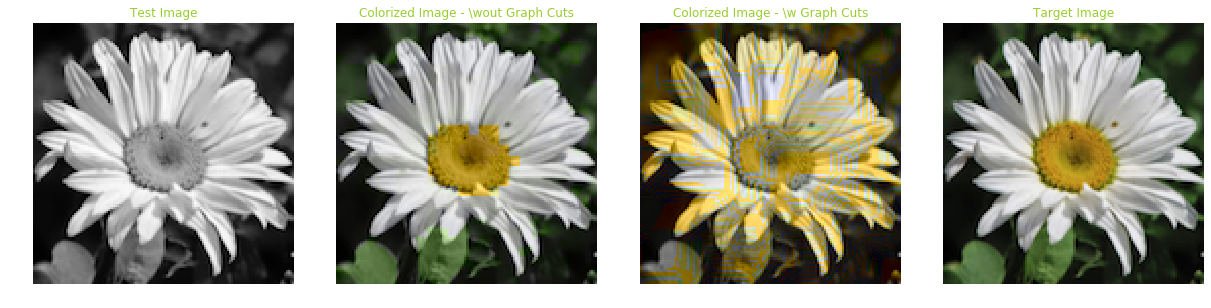

In [124]:
new_a_slice = np.zeros_like(test_image)
new_b_slice = np.zeros_like(test_image)

for i in np.arange(new_labels.shape[0]):
    for j in np.arange(new_labels.shape[1]):
        cc_index = colorClasses[new_labels[i,j]]
        pred_color_a = colorPalette.cluster_centers_[int(pred_color_class)][0]
        pred_color_b = colorPalette.cluster_centers_[int(pred_color_class)][1]

        new_a_slice[i,j] = colorPalette.cluster_centers_[cc_index][0]
        new_b_slice[i,j] = colorPalette.cluster_centers_[cc_index][1]
        

plt.figure(figsize=(17,17))
plt.subplot(1,4,1)
plt.axis('off')
plt.title('Test Image', color='yellowgreen')
plt.imshow(test_image, cmap='gray')
plt.subplot(1,4,2)
plt.axis('off')
plt.title('Colorized Image - \wout Graph Cuts', color='yellowgreen')
plt.imshow(lab2rgb(colorized_image))
plt.subplot(1,4,3)
plt.axis('off')
plt.title('Colorized Image - \w Graph Cuts', color='yellowgreen')
plt.imshow(lab2rgb(np.dstack((test_image, new_a_slice, new_b_slice))))
plt.subplot(1,4,4)
plt.axis('off')
plt.title('Target Image', color='yellowgreen')
plt.imshow(train_image_rgb)
plt.tight_layout()

In [125]:
gc_colorized_image = lab2rgb(np.dstack((test_image, new_a_slice, new_b_slice)))

In [126]:
gc_colorized_image = (gc_colorized_image*255).astype(np.uint8)

In [127]:
final_gc_colorized_image = gc_colorized_image.copy()
final_gc_colorized_image[:,:,1] = cv2.medianBlur(final_gc_colorized_image[:,:,1], 5)
final_gc_colorized_image[:,:,2] = cv2.medianBlur(final_gc_colorized_image[:,:,2], 5)

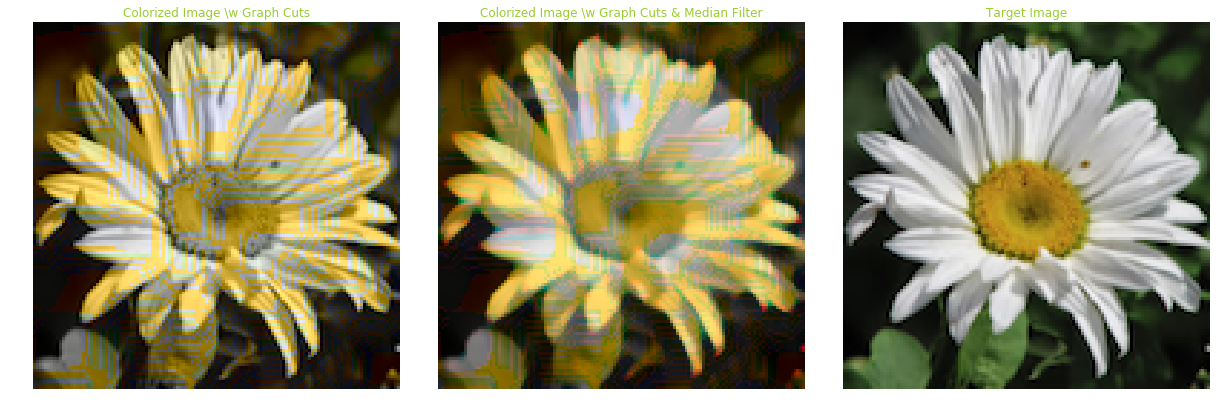

In [128]:
plt.figure(figsize=(17,17))
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Colorized Image \w Graph Cuts', color='yellowgreen')
plt.imshow(gc_colorized_image)
plt.subplot(1,3,2)
plt.axis('off')
plt.title('Colorized Image \w Graph Cuts & Median Filter', color='yellowgreen')
plt.imshow(final_gc_colorized_image)
plt.subplot(1,3,3)
plt.axis('off')
plt.title('Target Image', color='yellowgreen')
plt.imshow(train_image_rgb)
plt.tight_layout()